Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This solution, including any related sample code or data, is made available 
on an “as is,” “as available,” and “with all faults” basis, solely for 
illustrative purposes, and without warranty or representation of any kind. 
This solution is experimental, unsupported and provided solely for your 
convenience. Your use of it is subject to your agreements with Google, as 
applicable, and may constitute a beta feature as defined under those 
agreements.  To the extent that you make any data available to Google in 
connection with your use of the solution, you represent and warrant that you 
have all necessary and appropriate rights, consents and permissions to permit 
Google to use and process that data.  By using any portion of this solution, 
you acknowledge, assume and accept all risks, known and unknown, associated 
with its usage, including with respect to your deployment of any portion of 
this solution in your systems, or usage in connection with your business, 
if at all.

# Setup

### Load modules

In [65]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
!pip install --upgrade -q gspread 
import gspread
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
bigquery.USE_LEGACY_SQL = False

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' 
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery

!pip install relativeImp
from relativeImp import relativeImp

# data processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import seaborn as sns

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Load model input data

In [66]:
%%bigquery df
SELECT *
FROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`
WHERE Division IS NOT NULL;

In [67]:
df.columns

Index(['Division', 'day', 'total_clicks', 'NonBrand_clicks', 'Brand_clicks',
       'Brand_x_RMKT_x_EC_clicks', 'Brand_x_Core_x_NC_clicks',
       'NonBrand_x_Core_x_NC_clicks', 'Brand_x_RMKT_x_NCFM_clicks',
       'NonBrand_x_RMKT_x_NCFM_clicks',
       ...
       'DBM_x_Display_x_ACQ_imps', 'Pandora_x_Display_x_AWA_imps',
       'OTHER_x_Social_x_AWA_imps', 'The_Trade_Desk_x_Display_x_ACQ_imps',
       'Oath_x_Video_x_ACQ_imps', 'Division_y', 'new_accounts',
       'national_imps', 'national_clicks', '__index_level_0__'],
      dtype='object', length=158)

In [68]:
df = df[['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts']]

In [69]:
df = df.fillna(0)

In [70]:
df.describe()

,Brand_x_Core_x_NC_clicks,The_Trade_Desk_x_Audio_x_AWA_imps,DBM_x_Display_x_RTG_imps,Amazon_x_Display_x_AWA_imps,DBM_x_Video_x_AWA_imps,The_Trade_Desk_x_Display_x_AWA_imps,Brand_x_RMKT_x_EC_clicks,OTHER_x_Display_x_AWA_imps,Amazon_x_Display_x_RTG_imps,DBM_x_Display_x_ACQ_imps,Oath_x_Display_x_AWA_imps,DBM_x_Display_x_AWA_imps,new_accounts
count,607.000000,607.000000,6.070000e+02,6.070000e+02,6.070000e+02,607.000000,607.000000,6.070000e+02,6.070000e+02,6.070000e+02,607.000000,6.070000e+02,607.000000
mean,14329.436573,90002.678748,1.467573e+06,4.194357e+05,3.751410e+05,22417.869852,6327.876442,2.937962e+06,8.531091e+05,3.860112e+06,65537.889621,1.938495e+06,1500.762768
std,2300.490429,119544.592658,4.819902e+05,6.335222e+05,4.362467e+05,54948.202651,2882.918545,2.793634e+06,1.027559e+06,3.824958e+06,88365.995374,2.138514e+06,459.591467
min,7894.000000,0.000000,1.351720e+05,0.000000e+00,0.000000e+00,0.000000,2327.000000,1.390000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,365.000000
25%,12746.000000,0.000000,1.323660e+06,6.000000e+00,3.000000e+00,0.000000,4073.000000,6.477115e+05,0.000000e+00,2.027536e+06,0.000000,3.138890e+05,1174.000000
50%,14275.000000,42017.000000,1.557938e+06,9.819300e+04,2.407770e+05,0.000000,5298.000000,1.611886e+06,0.000000e+00,2.783977e+06,1.000000,1.202255e+06,1478.000000
75%,15913.000000,154324.000000,1.750654e+06,6.826945e+05,6.460510e+05,0.000000,8145.000000,5.092392e+06,1.666294e+06,4.409462e+06,117787.000000,2.465588e+06,1697.000000
max,21552.000000,786651.000000,2.433525e+06,2.859646e+06,2.889383e+06,319197.000000,16450.000000,1.034507e+07,4.003753e+06,2.050622e+07,395993.000000,8.800172e+06,3011.000000


## BQML Model

Run the model

In [98]:
%%bigquery
CREATE OR REPLACE MODEL `db-platform-sol.ComcastGBA_test.rba_model` 
OPTIONS (model_type='linear_reg',
         input_label_cols = ['new_accounts'])
AS SELECT Brand_x_Core_x_NC_clicks,
          The_Trade_Desk_x_Audio_x_AWA_imps,
          DBM_x_Display_x_RTG_imps, 
          Amazon_x_Display_x_AWA_imps,
          DBM_x_Video_x_AWA_imps, 
          The_Trade_Desk_x_Display_x_AWA_imps,
          Brand_x_RMKT_x_EC_clicks,  
          OTHER_x_Display_x_AWA_imps,
          Amazon_x_Display_x_RTG_imps, 
          DBM_x_Display_x_ACQ_imps,
          Oath_x_Display_x_AWA_imps,
          DBM_x_Display_x_AWA_imps,
       new_accounts
    FROM `db-platform-sol.ComcastGBA_test.ne_mains_clean`;

""


Output results (un-standardized)

In [99]:
%%bigquery bqml_results_unscaled
SELECT *
FROM ML.WEIGHTS(MODEL `db-platform-sol.ComcastGBA_test.rba_model`)

In [100]:
bqml_results_unscaled

,processed_input,weight,category_weights
0,Brand_x_Core_x_NC_clicks,0.153363,[]
1,The_Trade_Desk_x_Audio_x_AWA_imps,-0.001071,[]
2,DBM_x_Display_x_RTG_imps,0.000080,[]
3,Amazon_x_Display_x_AWA_imps,0.000086,[]
4,DBM_x_Video_x_AWA_imps,0.000129,[]
5,The_Trade_Desk_x_Display_x_AWA_imps,0.001864,[]
6,Brand_x_RMKT_x_EC_clicks,-0.050669,[]
7,OTHER_x_Display_x_AWA_imps,-0.000024,[]
8,Amazon_x_Display_x_RTG_imps,-0.000090,[]
9,DBM_x_Display_x_ACQ_imps,0.000045,[]


Output results (standardized)

In [101]:
%%bigquery bqml_results_scaled
SELECT
  *
FROM
  ML.WEIGHTS(MODEL `db-platform-sol.ComcastGBA_test.rba_model`,
    STRUCT(true AS standardize))

In [102]:
bqml_results_scaled

,processed_input,weight,category_weights
0,Brand_x_Core_x_NC_clicks,351.248455,[]
1,The_Trade_Desk_x_Audio_x_AWA_imps,-127.106733,[]
2,DBM_x_Display_x_RTG_imps,37.679770,[]
3,Amazon_x_Display_x_AWA_imps,57.273691,[]
4,DBM_x_Video_x_AWA_imps,55.506460,[]
5,The_Trade_Desk_x_Display_x_AWA_imps,140.096276,[]
6,Brand_x_RMKT_x_EC_clicks,-151.937216,[]
7,OTHER_x_Display_x_AWA_imps,-66.640444,[]
8,Amazon_x_Display_x_RTG_imps,-65.948474,[]
9,DBM_x_Display_x_ACQ_imps,168.553334,[]


### Evaluation

In [103]:
%%bigquery bqml_scores
SELECT *
FROM ML.EVALUATE(MODEL `db-platform-sol.ComcastGBA_test.rba_model`)

In [104]:
bqml_mae = bqml_scores.mean_absolute_error
bqml_rmse = np.sqrt(bqml_scores['mean_squared_error'])
bqml_scores['rmse'] = bqml_rmse

In [105]:
bqml_scores

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,192.344913,60998.916926,0.031564,166.108972,0.735002,0.735979,246.979588


#### Calculate relative importance of each tactic

In [106]:
yName = 'new_accounts'
xNames = ['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps']
df_results = relativeImp(df, outcomeName = yName, driverNames = xNames)

In [107]:
df_results

,driver,rawRelaImpt,normRelaImpt
0,Brand_x_Core_x_NC_clicks,0.438799,57.602715
1,The_Trade_Desk_x_Audio_x_AWA_imps,0.012567,1.649672
2,DBM_x_Display_x_RTG_imps,0.039293,5.158105
3,Amazon_x_Display_x_AWA_imps,0.049373,6.481381
4,DBM_x_Video_x_AWA_imps,0.043450,5.703847
5,The_Trade_Desk_x_Display_x_AWA_imps,0.062278,8.175426
6,Brand_x_RMKT_x_EC_clicks,0.040925,5.372351
7,OTHER_x_Display_x_AWA_imps,0.014191,1.862876
8,Amazon_x_Display_x_RTG_imps,0.010347,1.358337
9,DBM_x_Display_x_ACQ_imps,0.010533,1.382645


In [108]:
df_results['rawRelaImpt'].sum()

0.7617686540559064

In [109]:
df_results['normRelaImpt'].sum()

99.99999999999997

# Validate Linear Regression Model Assumptions

Generate model predictions and residuals

In [110]:
%%bigquery model_predictions
SELECT
  predicted_new_accounts, new_accounts
FROM
  ML.PREDICT(MODEL `db-platform-sol.ComcastGBA_test.rba_model`,
    (
    SELECT
        *
    FROM
      `db-platform-sol.ComcastGBA_test.ne_mains_clean`));

In [111]:
model_predictions['residuals'] = model_predictions.predicted_new_accounts - model_predictions.new_accounts

In [112]:
bqml_results_scaled

,processed_input,weight,category_weights
0,Brand_x_Core_x_NC_clicks,351.248455,[]
1,The_Trade_Desk_x_Audio_x_AWA_imps,-127.106733,[]
2,DBM_x_Display_x_RTG_imps,37.679770,[]
3,Amazon_x_Display_x_AWA_imps,57.273691,[]
4,DBM_x_Video_x_AWA_imps,55.506460,[]
5,The_Trade_Desk_x_Display_x_AWA_imps,140.096276,[]
6,Brand_x_RMKT_x_EC_clicks,-151.937216,[]
7,OTHER_x_Display_x_AWA_imps,-66.640444,[]
8,Amazon_x_Display_x_RTG_imps,-65.948474,[]
9,DBM_x_Display_x_ACQ_imps,168.553334,[]


####1. Linearity

Visually inspect linearity between target variable and predictions

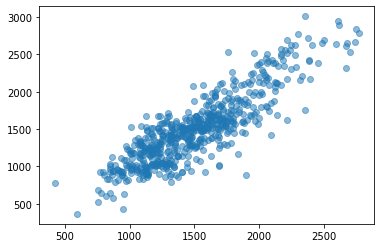

In [113]:
plt.plot(model_predictions.predicted_new_accounts,model_predictions.new_accounts,'o',alpha=0.5)
plt.show()

#### 2. Normality of Errors

Visually inspect the residuals to confirm normality

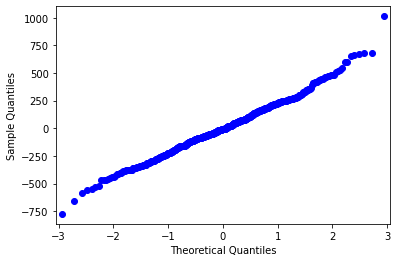

In [114]:
fig = sm.qqplot(model_predictions.residuals)

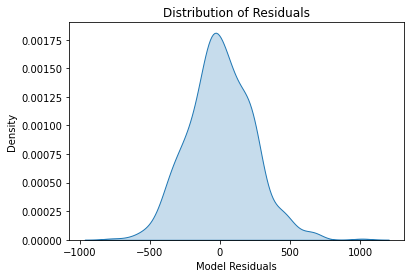

In [115]:
sns.kdeplot(model_predictions.residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

####3. Absence of Multicollinearity

Tested and checked during data processing stage

####4. Homoscedasticity


Visually inspect residuals to confirm constant variance

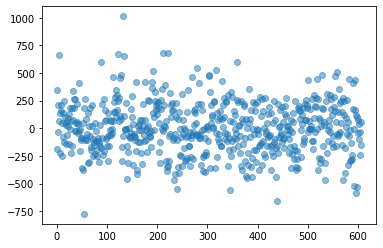

In [116]:
plt.plot(model_predictions.residuals,'o',alpha=0.5)
plt.show()

####5. Absence of Autocorrelation of the residuals

In [117]:
dw = durbin_watson(model_predictions.residuals)
print('Durbin-Watson',dw)

Durbin-Watson 1.884469309227099


In [118]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 



### Export Results

In [119]:
planning_data = bqml_results_scaled
planning_data.drop(columns = ['category_weights'], inplace = True)

In [120]:
sum_impressions = list()
for i in planning_data.processed_input:
  if i == '__INTERCEPT__':
    sum_impressions.append(0)
  else:
    sum_impressions.append(df[i].sum())

planning_data['impressions/clicks'] = sum_impressions
planning_data

,processed_input,weight,impressions/clicks
0,Brand_x_Core_x_NC_clicks,351.248455,8.697968e+06
1,The_Trade_Desk_x_Audio_x_AWA_imps,-127.106733,5.463163e+07
2,DBM_x_Display_x_RTG_imps,37.679770,8.908170e+08
3,Amazon_x_Display_x_AWA_imps,57.273691,2.545975e+08
4,DBM_x_Video_x_AWA_imps,55.506460,2.277106e+08
5,The_Trade_Desk_x_Display_x_AWA_imps,140.096276,1.360765e+07
6,Brand_x_RMKT_x_EC_clicks,-151.937216,3.841021e+06
7,OTHER_x_Display_x_AWA_imps,-66.640444,1.783343e+09
8,Amazon_x_Display_x_RTG_imps,-65.948474,5.178372e+08
9,DBM_x_Display_x_ACQ_imps,168.553334,2.343088e+09
